# Regressing lane lines

In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload

In [2]:
import sys
sys.path.append("..")

%autoreload 2
from pipeline import LaneColorMasking, EdgeDetection, EdgeDetectionSWT
from scripts.processing import undistort_and_warp, build_roi_mask
from scripts.channels import show_single_image, show_two_images
from scripts.conversion import bgr2lab
roi_mask = build_roi_mask()

In [3]:
friendly_paths = glob.glob(os.path.join('..', 'test_images', 'test*.jpg'))
hard_paths = glob.glob(os.path.join('..', 'test_images', 'challenge*.jpg'))
len(friendly_paths), len(hard_paths)

(6, 9)

In [4]:
def get_test_image(i: int, resize: bool=True, hard: bool=True) -> np.ndarray:
    img = cv2.imread(hard_paths[i] if hard else friendly_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (0, 0), fx=0.25, fy=0.25) if resize else img

First we define the edge and color detection instances:

In [5]:
edg = EdgeDetection(detect_lines=False, mask=roi_mask)
edg.filter_threshold = .03

swt = EdgeDetectionSWT(mask=roi_mask)

lcm = LaneColorMasking()
lcm.detect_lines = False
lcm.blue_threshold = 25
lcm.light_cutoff = .9

Then we obtain and combine the masks.

In [6]:
def get_mask(frame: np.ndarray, edg: EdgeDetection, lcm: LaneColorMasking, additive: bool=True) -> np.ndarray:
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    mask_l, mask_b = lcm.process(lab, is_lab=True)
    if additive:
        filtered = edg.filter(lab, is_lab=True)
        mask_sum = np.float32(filtered) / filtered.max()
        mask_sum += np.float32(mask_l) / 255.
        mask_sum += np.float32(mask_b) / 255.
        return (mask_sum / 3) ** 2
    edges = edg.detect(lab, is_lab=True)
    mask_le = mask_l & edges
    mask_be = mask_b & edges
    mask_lb = mask_l & mask_b
    mask = mask_lb | mask_le | mask_be
    return mask

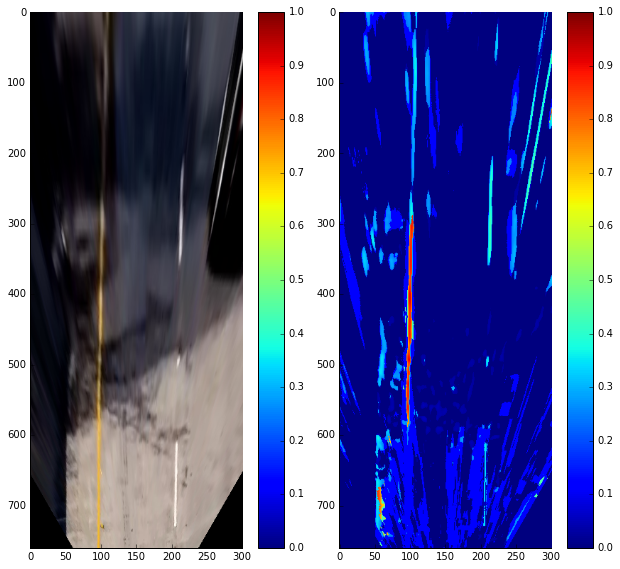

In [8]:
test_img = get_test_image(0, resize=False, hard=False)
warped = undistort_and_warp(test_img)
mask = get_mask(warped, edg, lcm)
show_two_images(warped, mask, vmin=0, vmax=1, cmap='jet', colorbar=True)

In [9]:
%%timeit
get_mask(warped, edg, lcm)

18.4 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


And now the same with SWT.

In [10]:
%%timeit
get_mask(warped, swt, lcm)

735 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


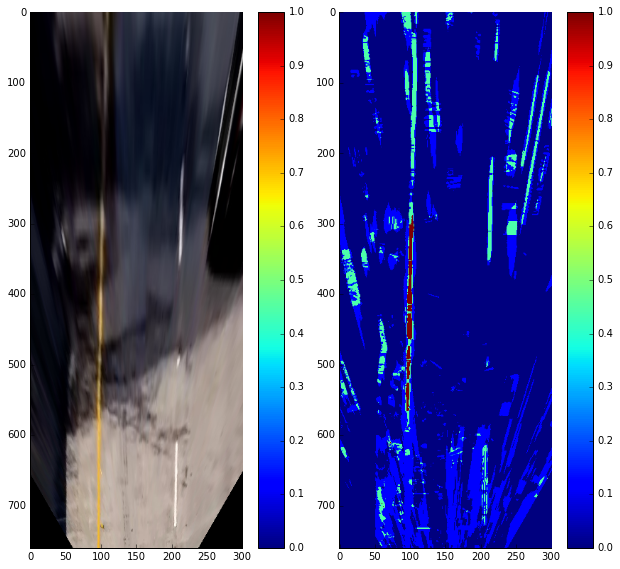

In [11]:
test_img = get_test_image(0, resize=False, hard=False)
warped = undistort_and_warp(test_img)
mask = get_mask(warped, swt, lcm)
show_two_images(warped, mask, vmin=0, vmax=1, cmap='jet', colorbar=True)

While the image appears to look slightly better, this method is about 50 times slower. Granted, it is not
optimized for performance and will run differently in a multithreaded system (for each edge pixel, we're following a beam across the image), but this kind of speed difference
is likely pathological.

## Initialization of search with the additive mask

One simple approach of generating lane line assumptions is to obtain actual line segments / points e.g. via the Hough transform, then using RANSAC to obtain and/or discard matching lanes.

In this approach, we're performing a simple search from the bottom of the frame up in order to then regress a spline.

First, we're starting at a friendly location where we know lane lines exist.

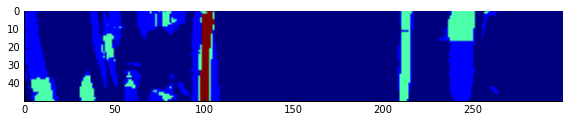

In [12]:
window_nice = mask[300:350, ...]
show_single_image(window_nice, cmap='jet', vmin=0, vmax=1)

In [13]:
def build_histogram(window: np.ndarray, binwidth: int=20, binstep: int=20) -> np.ndarray:
    half_binwidth = binwidth // 2
    bins = np.uint32(np.arange(half_binwidth, window.shape[1] - half_binwidth, binstep))
    histogram = np.zeros(shape=len(bins), dtype=np.float32)
    for i, x in enumerate(bins):
        left = max(x - half_binwidth, 0)
        right = min(x + half_binwidth, window.shape[1])
        bin_area = window.shape[0] * (right - left)
        histogram[i] = np.sum(window[:, left:right]) / bin_area
    return histogram, bins

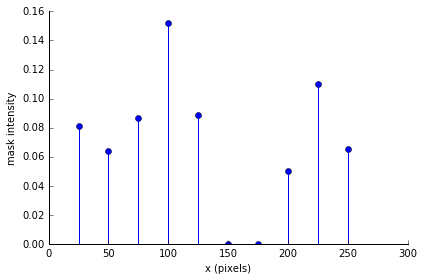

In [15]:
def plot_histogram(window: np.ndarray, histogram: np.ndarray, bins: np.ndarray):
    plt.stem(bins, histogram)
    plt.xlim([0, window.shape[1]])
    plt.xlabel('x (pixels)')
    plt.ylabel('mask intensity')
    plt.tight_layout()
    sns.despine()
    
histogram_nice, bins_nice = build_histogram(window_nice, 50, 25)
plot_histogram(window_nice, histogram_nice, bins_nice)

In [111]:
from typing import List

def find_maxima(histogram: np.ndarray, bins: np.ndarray, epsilon: float=.0, k: int=0) -> List[int]:
    maxima, heights = [], []
    if histogram[0] > (histogram[1] + epsilon):
        maxima.append(bins[0])
        heights.append(histogram[0])
    for i in range (1, histogram.shape[0] - 1):
        left_smaller = histogram[i] > (histogram[i - 1] + epsilon)
        right_smaller = histogram[i] > (histogram[i + 1] + epsilon)
        if left_smaller and right_smaller:
            maxima.append(bins[i])
            heights.append(histogram[i])
    if histogram[-1] > (histogram[-2] + epsilon):
        maxima.append(bins[-1])
        heights.append(histogram[-1])
        
    if k > 0:
        idxs = np.array(heights).argsort()[-k:][::-1]
        maxima = np.array(maxima)[idxs].tolist()
        heights = np.array(heights)[idxs].tolist()
    return maxima, heights

find_maxima(histogram_nice, bins_nice)

([1, 4, 9], [0.081360057, 0.15188065, 0.11004872])

In [112]:
find_maxima(histogram_nice, bins_nice, k=2)

([4, 9], [0.1518806517124176, 0.11004871875047684])

Given this, we would start our search at x=100 and x=225, which is pretty close to the truth.

However, if we start from the bottom of the image, this is what we really see:

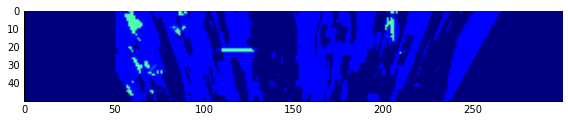

In [49]:
window_hard = mask[mask.shape[0]-50:, ...]
show_single_image(window_hard, cmap='jet', vmin=0, vmax=1)

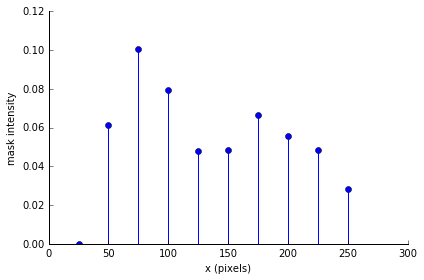

In [102]:
histogram_hard, bins_hard = build_histogram(window_hard, 50, 25)
plot_histogram(window_hard, histogram_hard, bins_hard)

In [51]:
find_maxima(histogram_hard, bins_hard)

([75, 175], [0.10034417, 0.066464223])

Here, the algorithm is biased to the left, were it would start at x=75 and x=175.

## Initialization from the binary mask

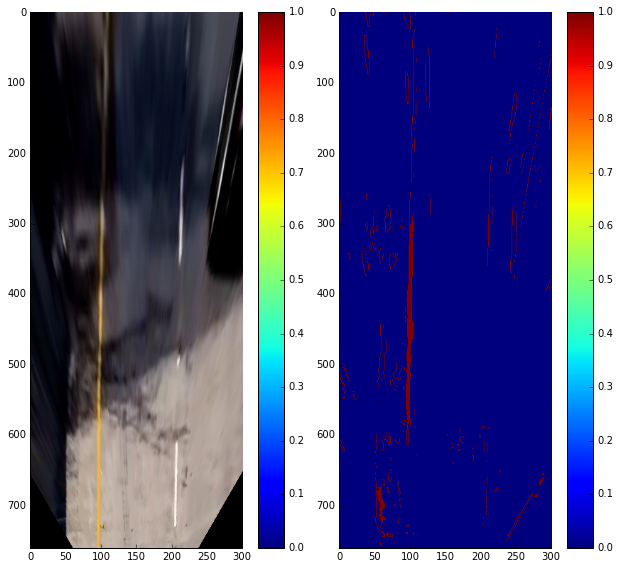

In [52]:
mask_b = get_mask(warped, edg, lcm, additive=False)
show_two_images(warped, mask_b, vmin=0, vmax=1, cmap='jet', colorbar=True)

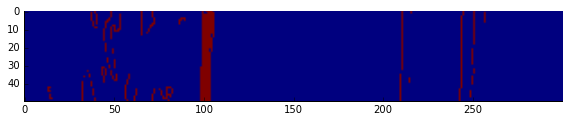

In [53]:
window_nice_b = mask_b[300:350, ...]
show_single_image(window_nice_b, cmap='jet', vmin=0, vmax=1)

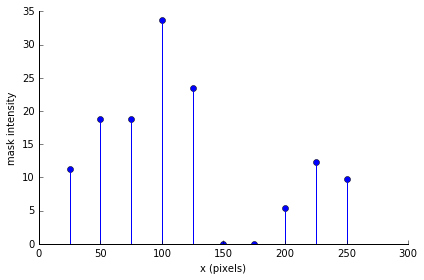

In [54]:
histogram_nice_b, bins_nice_b = build_histogram(window_nice_b, 50, 25)
plot_histogram(window_nice_b, histogram_nice_b, bins_nice_b)

In [55]:
find_maxima(histogram_nice_b, bins_nice_b)

([50, 100, 225], [18.870001, 33.66, 12.342])

This is an interesting twist. As it turns out, the search would be initialized as x=100, x=225 and x=50. As we'll find, x=50 actually is the second-highest maximum:

In [56]:
histogram_nice_b

array([ 11.22000027,  18.87000084,  18.76799965,  33.65999985,
        23.45999908,   0.        ,   0.        ,   5.40600014,
        12.34200001,   9.79199982], dtype=float32)

We can enforce a minimum value by which a bin must be bigger than its surroundings to consider it a maximum.
This could lead to trouble, eventually.

In [57]:
find_maxima(histogram_nice_b, bins_nice_b, epsilon=0.2)

([100, 225], [33.66, 12.342])

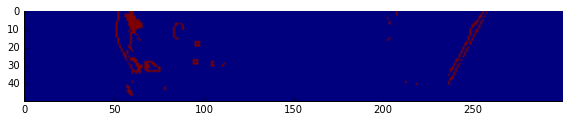

In [58]:
window_hard_b = mask_b[mask_b.shape[0]-50:, ...]
show_single_image(window_hard_b, cmap='jet', vmin=0, vmax=1)

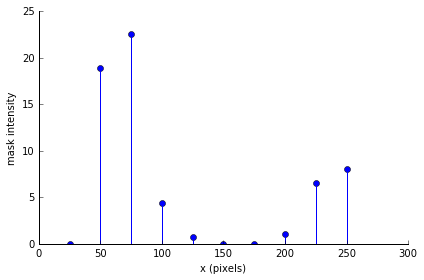

In [60]:
histogram_hard_b, bins_hard_b = build_histogram(window_hard_b, 50, 25)
plot_histogram(window_hard_b, histogram_hard_b, bins_hard_b)

In [61]:
find_maxima(histogram_hard_b, bins_hard_b)

([75, 250], [22.542, 8.0579996])

Exactly what we expected. The x=250 estimate will eventually move the search window to the screen 
border, resulting in a valid regression, yet a severly wrong line.

With the current setup, we know that the lines are going to be positioned at x=100 and x=200, assuming the car
is driving centered on the lane, the lane widths are somewhat standard and the observed XZ plane is level (which isn't the case especially in the hard challenge video).
This means that we could run two additional searches, starting at these positions, in order to obtain 
a stable estimate even when the boundaries of the frame contain noise.

Much like non-maxima suppression was performed for finding the peaks in the histograms, we can run it 
on the search window as well. This combines the benefits of all estimates voting for the lane line, 
while still having a sharp binary mask.

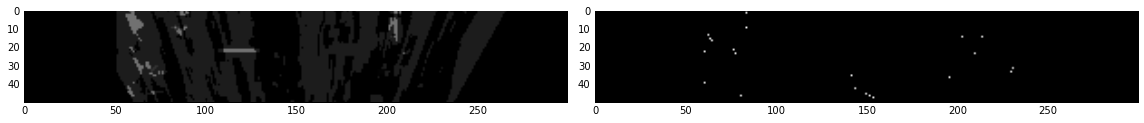

In [62]:
def window_nms_0(window: np.ndarray, epsilon: float=0) -> np.ndarray:
    mask = np.zeros_like(window)
    for y in range(1, window.shape[0]-1):
        for x in range(1, window.shape[1]-1):
            value = window[y, x]
            gt_top = value > (window[y-1, x] + epsilon)
            gt_left = value > (window[y, x-1] + epsilon)
            gt_right = value > (window[y, x+1] + epsilon)
            gt_bottom = value > (window[y+1, x] + epsilon)
            mask[y, x] = int(gt_top and gt_left and gt_right and gt_bottom)
    return mask

window_hard_nms = window_nms_0(window_hard)
show_two_images(window_hard, window_hard_nms, vmin=0, vmax=1, cmap='gray', size=(16, 3))

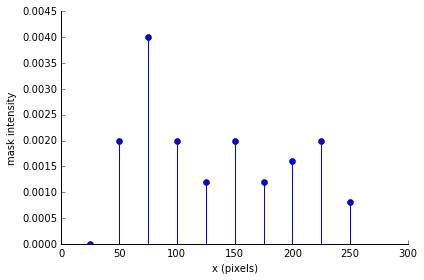

In [64]:
histogram_hard_nms, bins_hard_nms = build_histogram(window_hard_nms, 50, 25)
plot_histogram(window_hard_nms, histogram_hard_nms, bins_hard_nms)

In [65]:
find_maxima(histogram_hard_nms, bins_hard_nms)

([75, 150, 225], [0.0040000002, 0.0020000001, 0.0020000001])

While that is still not correct for the left lane (as it cannot be), the right lane is now much closer to what we expect.

A problem with this approach is that we might be suppressing pixels that are on a plateau. An revised metric might be that the pixels mustn't be smaller than any of its surroundings yet might be the same size as the others.

The other options implement a soft version of this, where pixels are weighted according to their "maximum-ness".

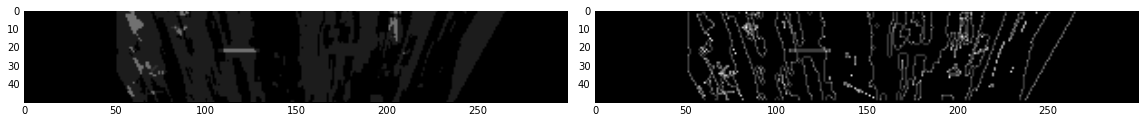

In [66]:
def window_nms_1(window: np.ndarray, epsilon: float=0) -> np.ndarray:
    mask = np.zeros_like(window)
    for y in range(1, window.shape[0]-1):
        for x in range(1, window.shape[1]-1):
            value = window[y, x]
            sum_ = 0
            if value > (window[y-1, x] + epsilon):
                sum_ += 0.25
            if value > (window[y, x-1] + epsilon):
                sum_ += 0.25
            if value > (window[y, x+1] + epsilon):
                sum_ += 0.25
            if value > (window[y+1, x] + epsilon):
                sum_ += 0.25
            mask[y, x] = sum_
    return mask

window_hard_nms = window_nms_1(window_hard)
show_two_images(window_hard, window_hard_nms, vmin=0, vmax=1, cmap='gray', size=(16, 3))

In [69]:
histogram_hard_nms, bins_hard_nms = build_histogram(window_hard_nms, 50, 25)
find_maxima(histogram_hard_nms, bins_hard_nms)

([75, 200], [0.074600004, 0.072700001])

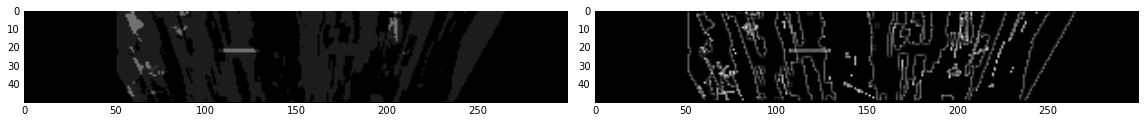

In [70]:
def window_nms_2(window: np.ndarray, epsilon: float=0) -> np.ndarray:
    mask = np.zeros_like(window)
    for y in range(1, window.shape[0]-1):
        for x in range(1, window.shape[1]-1):
            value = window[y, x]
            sum_ = 0
            if value > (window[y-1, x-1] + epsilon):
                sum_ += 0.125
            if value > (window[y-1, x] + epsilon):
                sum_ += 0.125
            if value > (window[y-1, x+1] + epsilon):
                sum_ += 0.125
            if value > (window[y, x-1] + epsilon):
                sum_ += 0.125
            if value > (window[y, x+1] + epsilon):
                sum_ += 0.125
            if value > (window[y+1, x-1] + epsilon):
                sum_ += 0.125
            if value > (window[y+1, x] + epsilon):
                sum_ += 0.125
            if value > (window[y+1, x+1] + epsilon):
                sum_ += 0.125
            mask[y, x] = sum_
    return mask

window_hard_nms = window_nms_2(window_hard)
show_two_images(window_hard, window_hard_nms, vmin=0, vmax=1, cmap='gray', size=(16, 3))

In [71]:
histogram_hard_nms, bins_hard_nms = build_histogram(window_hard_nms, 50, 25)
find_maxima(histogram_hard_nms, bins_hard_nms)

([75, 200], [0.086549997, 0.089299999])

## Obtaining an initial guess

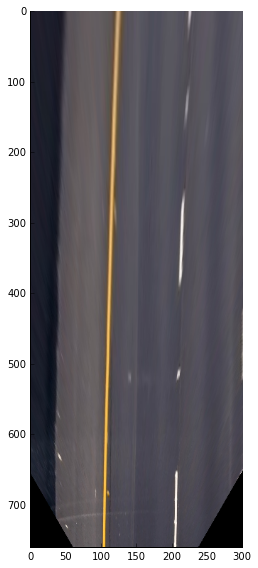

In [72]:
test_img = get_test_image(2, resize=False, hard=False)
warped = undistort_and_warp(test_img)
show_single_image(warped)

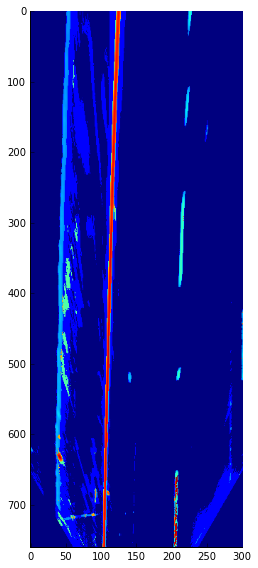

In [73]:
mask = get_mask(warped, edg, lcm)
show_single_image(mask, cmap='jet')

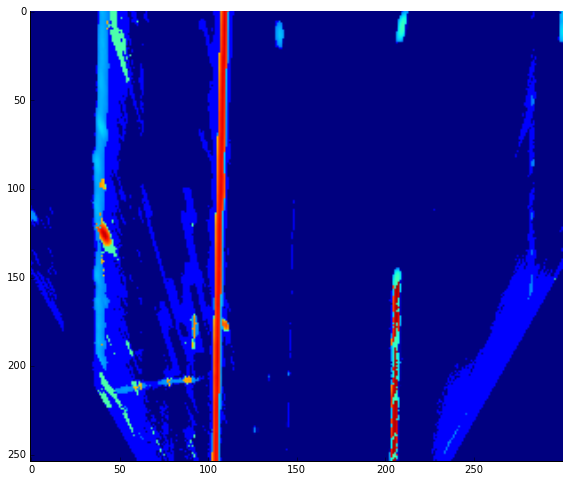

In [127]:
mask = get_mask(warped, edg, lcm)
window_nice = mask[-mask.shape[0]//3:, ...]
show_single_image(window_nice, cmap='jet', vmin=0, vmax=1)

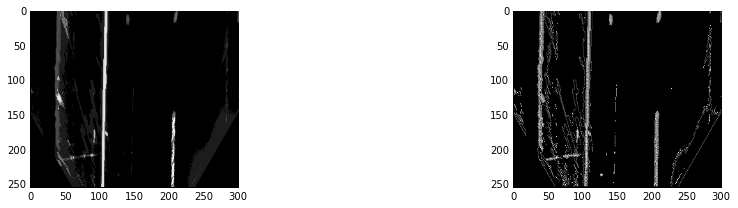

In [128]:
window_nice_nms = window_nms_1(window_nice)
show_two_images(window_nice, window_nice_nms, vmin=0, vmax=1, cmap='gray', size=(16, 3))

In [131]:
hist_window_nice, bins_nice = build_histogram(window_nice, 2, 1)
maxima = find_maxima(hist_window_nice, bins_nice, k=2)
maxima

([106, 206], [0.6784936785697937, 0.32318079471588135])

In [130]:
hist_window_nice_nms, bins_nice_nms = build_histogram(window_nice_nms, 2, 1)
find_maxima(hist_window_nice_nms, bins_nice_nms, k=3)

([107, 39, 206],
 [0.49803149700164795, 0.44389763474464417, 0.2662401497364044])

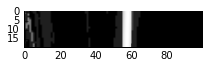

In [243]:
def get_window(mask: np.ndarray, seed_x: int, seed_y: int, box_width: int=50, box_height: int=50):   
    hbw = box_width // 2
    xl = seed_x - hbw
    xr = xl + box_width
    yb = seed_y
    yt = yb - box_height
    
    h, w = mask.shape[:2]
    xl_ = max(0, xl)
    yt_ = max(0, yt)
    xr_ = min(w-1, xr)
    yb_ = min(h-1, yb)
    return mask[yt_:yb_, xl_:xr_, ...], (xl, yt, xr, yb)

show_single_image(get_window(mask, 106, 350, box_width=100, box_height=20)[0], size=(3, 3))

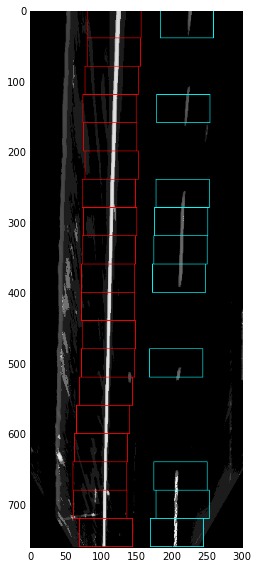

In [261]:
def search_track(mask: np.ndarray, seed_x: int, seed_y: int, 
                 box_width: int=50, box_height: int=50, threshold: float=20):

    rects, xs, ys = [], [], []
    h, w = mask.shape[:2]
    while True:
        window, rect = get_window(mask, seed_x, seed_y, box_width, box_height)      
        
        # Obtain the centroid for the next window
        col_sums = np.squeeze(window.sum(axis=0))
        total = col_sums.sum()
        valid = total > threshold
        if valid:
            rects.append(rect)
            xs.append(seed_x)
            ys.append(seed_y)
            indexes = np.arange(0, col_sums.shape[0])
            seed_x = rect[0] + np.int32(np.average(indexes, weights=col_sums))
        
        # Now stop if we left the window
        if rect[0] < 0 or rect[0] >= w or rect[1] < -box_height:
            break
                       
        # Update the seeds
        seed_y = rect[1]
        window, rect = get_window(mask, seed_x, seed_y, box_width, box_height)
    return rects, xs, ys

track_l, xs_l, ys_l = search_track(mask, 106, mask.shape[0]-1, box_width=75, box_height=40, threshold=20)
track_r, xs_r, ys_r = search_track(mask, 206, mask.shape[0]-1, box_width=75, box_height=40, threshold=20)

mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
for rect in track_l:
    cv2.rectangle(mask_color, rect[:2], rect[2:], color=(1, 0, 0), thickness=1)
for rect in track_r:
    cv2.rectangle(mask_color, rect[:2], rect[2:], color=(0, 1, 1), thickness=1)
show_single_image(mask_color)

In [262]:
fit_l = np.polyfit(ys_l, xs_l, deg=2)
fit_r = np.polyfit(ys_r, xs_r, deg=2)

In [263]:
ploty = np.linspace(mask_color.shape[0]-1, 0, mask_color.shape[0])
ploty[:10]

array([ 759.,  758.,  757.,  756.,  755.,  754.,  753.,  752.,  751.,  750.])

In [264]:
fitx_l = fit_l[0]*ploty**2 + fit_l[1]*ploty + fit_l[2]
fitx_r = fit_r[0]*ploty**2 + fit_r[1]*ploty + fit_r[2]

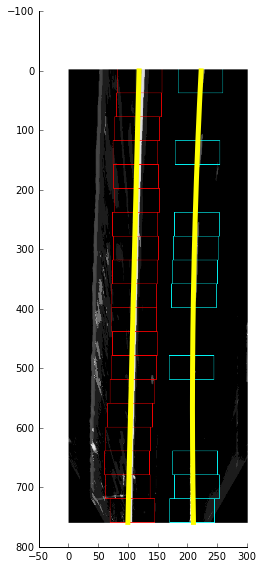

In [265]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.imshow(mask_color)
ax.plot(fitx_l, ploty, color='yellow', linewidth=5)
ax.plot(fitx_r, ploty, color='yellow', linewidth=5)
plt.tight_layout()
sns.despine()

## Test on a harder example

In [441]:
def regress_lanes(mask: np.ndarray, k: int=2, 
                  box_width: int=75, box_height: int=40, threshold: int=20, 
                  degree: int=2, search_height: int=4):
    h, w = mask.shape[:2]
    window = mask[-h//search_height:, ...]
    hist, bins = build_histogram(window, 2, 1)
    maxima, values = find_maxima(hist, bins, k=k)
    
    fits, rects = [], []
    for m in maxima:
        track, xs, ys = search_track(mask, m, h-1, 
                                     box_width=box_width,
                                     box_height=box_height,
                                     threshold=threshold)
        fits.append(np.polyfit(ys, xs, deg=degree))
        rects.append(track)
    return fits, rects

In [386]:
def plot_lanes(img, mask, fits, rects):
    h, w = img.shape[:2]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8), sharex=False, sharey=False)
    axs[0].imshow(img)
    axs[1].imshow(mask)
    ys = np.linspace(h-1, 0, h)   
    coords = []
    if rects is None:
        rects = [None]**len(fits)
    for fit, track in zip(fits, rects):
        #xs = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        xs = np.polyval(fit, ploty)
        axs[0].plot(xs, ys, color='red', linewidth=5)
    axs[0].set_xlim([0, w])
    axs[1].set_xlim([0, w])
    axs[0].set_ylim([h, 0])
    axs[1].set_ylim([h, 0])
    plt.tight_layout()
    sns.despine()

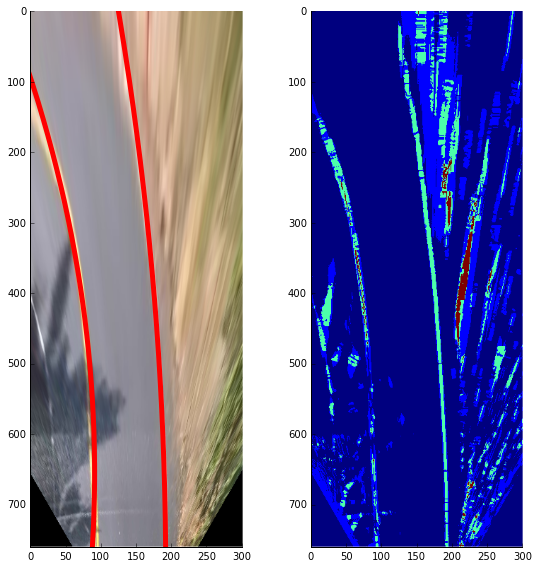

In [453]:
test_img = get_test_image(2, resize=False, hard=True)
warped = undistort_and_warp(test_img)
mask = get_mask(warped, swt, lcm)
fits, rects = regress_lanes(mask, k=2, search_height=4, box_width=25, box_height=15, threshold=15, degree=2)
plot_lanes(warped, mask, fits, rects)

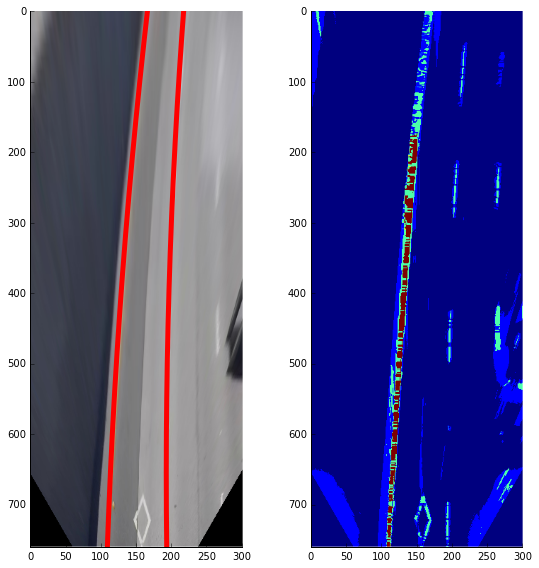

In [454]:
test_img = get_test_image(3, resize=False, hard=True)
warped = undistort_and_warp(test_img)
mask = get_mask(warped, swt, lcm)
fits, rects = regress_lanes(mask, k=2, search_height=4, box_width=25, box_height=15, threshold=15, degree=2)
plot_lanes(warped, mask, fits, rects)

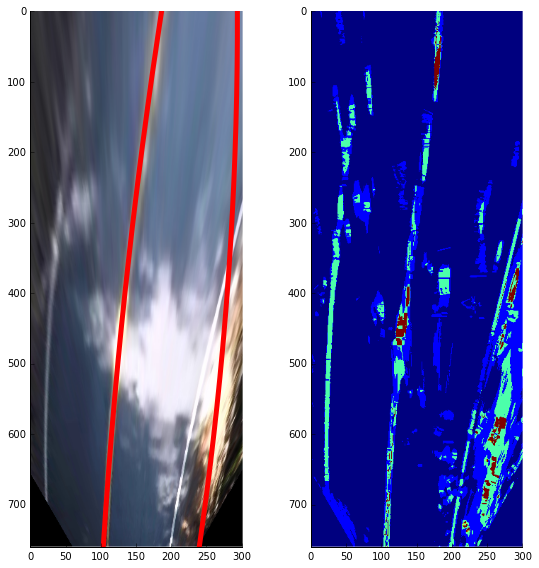

In [465]:
test_img = get_test_image(5, resize=False, hard=True)
warped = undistort_and_warp(test_img)
mask = get_mask(warped, swt, lcm)
fits, rects = regress_lanes(mask, k=2, search_height=5, box_width=25, box_height=15, threshold=15, degree=2)
plot_lanes(warped, mask, fits, rects)

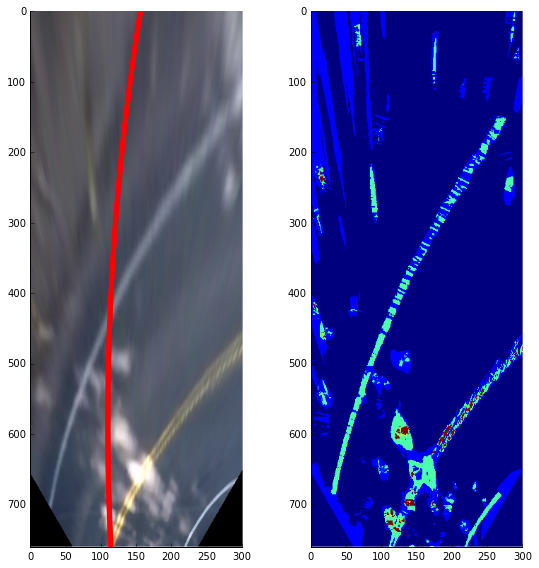

In [477]:
test_img = get_test_image(6, resize=False, hard=True)
warped = undistort_and_warp(test_img)
mask = get_mask(warped, swt, lcm)
fits, rects = regress_lanes(mask, k=2, search_height=10, box_width=20, box_height=10, threshold=15, degree=2)
plot_lanes(warped, mask, fits, rects)